In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

from datetime import datetime
from dateutil.parser import parse
from numpy import linspace

%matplotlib inline


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines',markerfacecolor='w')

# Data

## soil moisture

In [2]:
ap1_sm = pd.read_excel('./TDR_soil_moisture/AP1_SM.xlsx',index_col='date')
mut_sm = pd.read_excel('./TDR_soil_moisture/MUT_SM.xlsx',index_col='date')
f1_sm = pd.read_excel('./TDR_soil_moisture/F1_SM.xlsx',index_col='date')
k1_sm = pd.read_excel('./TDR_soil_moisture/K1_SM.xlsx',index_col='date')

In [4]:
peaks = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='peaks')
peaks_final = peaks[peaks['speculative'] != 'yes']
peaks_land = peaks_final.groupby('landuse')

## DI extractions and lysimeters

In [8]:
# lysimeter soils dataframe
soil = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='physical_props')
soil_dry = pd.concat([soil['sample'],soil['extract_dry_mass_kg'],soil['GWC']],axis=1)
dil_factor = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='DI_extract_calcs')
bulk_den = soil[soil['BD']=='BD'].loc[:,['Loc','sample','depth','dry_bulk_density']]
bulk_den['dry_bulk_kgm3'] = bulk_den['dry_bulk_density'] * 1000

# groundwater ion dataframe
ion_gw = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='GW_transect_wells',na_values='n.a.')

# create lysimeter ion dataframe
ion_lys = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='lysimeter_mM',na_values='n.a.')

ion_lys['sample'] = ion_lys['sample'].str.split('-')

for i in ion_lys.index:
    ion_lys.loc[i,'location'] = ion_lys.loc[i,'sample'][0]
    ion_lys.loc[i,'depth'] = float(ion_lys.loc[i,'sample'][1])
    ion_lys.loc[i,'type'] = ion_lys.loc[i,'sample'][2]
    
    ion_lys.loc[i,'date'] = parse(ion_lys.loc[i,'sample'][3],yearfirst=True)
ion_lys.sort_values('date',inplace=True)
ion_lys_pan = ion_lys[ion_lys['type'] == 'PAN']
ion_lys.drop(ion_lys[ion_lys['type'] == 'PAN'].index,inplace=True)
ion_lys.reset_index(drop=True,inplace=True)

ion_lys['cl/no3_mM'] = ion_lys['chloride_mM'] / ion_lys['nitrate_mM']
ion_lys['so4/no3_mM'] = ion_lys['sulfate_mM'] / ion_lys['nitrate_mM']

gwc = []
for s in range(len(ion_lys)):
    loc = ion_lys.location[s]
    depth = str(ion_lys.depth[s])+' m'
    date = str(ion_lys.date.dt.date[s])
    if loc == 'AP1':
        # find the bulk density for the sample loc and depth. g/cm3 == kg/L
        bd = soil.loc[(soil['Loc'] == loc) & (soil['depth'] == ion_lys.depth[s]),'dry_bulk_density'].values[0]
        # calculate GWC = VWC / BD
        grav = ap1_sm[date][depth].mean() / bd
    elif loc == 'MUT':
        bd = soil.loc[(soil['Loc'] == loc) & (soil['depth'] == ion_lys.depth[s]),'dry_bulk_density'].values[0]
        try:
            grav = mut_sm[date][depth].mean() / bd
        except:
            grav = ap1_sm[date][depth].mean() / bd
    elif loc == 'F1':
        bd = soil.loc[(soil['Loc'] == loc) & (soil['depth'] == ion_lys.depth[s]),'dry_bulk_density'].values[0]
        grav = f1_sm[date][depth].mean() / bd
        if np.isnan(grav):
            grav = ap1_sm[date][depth].mean() / bd
    else:
        bd = soil.loc[(soil['Loc'] == loc) & (soil['depth'] == ion_lys.depth[s]),'dry_bulk_density'].values[0]
        try:
            grav = k1_sm[date][depth].mean() / bd
        except:
            grav = ap1_sm[date][depth].mean() / bd 
    gwc.append(grav)
ion_lys['GWC'] = gwc
ion_lys['nitrate_mmolkg'] = ion_lys['nitrate_mM'] * ion_lys['GWC']

In [14]:
# di blanks dataframe
di_blanks = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='DI_blanks',
                        na_values='n.a.')
# create di extraction ion dataframe
ion_ext = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='DI_mM',
                        na_values='n.a.')
# add in dry mass and calculate dry concentrations.
ion_ext = ion_ext.merge(soil_dry, on='sample')
ion_ext = ion_ext.merge(dil_factor[['sample','ext_dil_factor']],on='sample')

# 0.05 L is the volume of extractant we used
ion_ext['nitrate_mmolkg'] = (ion_ext['nitrate_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']
ion_ext['chloride_mmolkg'] = (ion_ext['chloride_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']
ion_ext['sulfate_mmolkg'] = (ion_ext['sulfate_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']
ion_ext['mg_mmolkg'] = (ion_ext['mg_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']
ion_ext['k_mmolkg'] = (ion_ext['k_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']
ion_ext['na_mmolkg'] = (ion_ext['na_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']
ion_ext['ca_mmolkg'] = (ion_ext['ca_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']
ion_ext['p_mmolkg'] = (ion_ext['p_mM'] * 0.05) / ion_ext['extract_dry_mass_kg']

# calc of pore water by accounting for dilution
ion_ext['nitrate_mMsoil'] = ion_ext['nitrate_mM'] * ion_ext['ext_dil_factor']
ion_ext['chloride_mMsoil'] = ion_ext['chloride_mM'] * ion_ext['ext_dil_factor']
ion_ext['sulfate_mMsoil'] = ion_ext['sulfate_mM'] * ion_ext['ext_dil_factor']
ion_ext['mg_mMsoil'] = ion_ext['mg_mM'] * ion_ext['ext_dil_factor']
ion_ext['k_mMsoil'] = ion_ext['k_mM'] * ion_ext['ext_dil_factor']
ion_ext['na_mMsoil'] = ion_ext['na_mM'] * ion_ext['ext_dil_factor']
ion_ext['ca_mMsoil'] = ion_ext['ca_mM'] * ion_ext['ext_dil_factor']
ion_ext['p_mMsoil'] = ion_ext['p_mM'] * ion_ext['ext_dil_factor']

ion_ext['cl/no3_mMsoil'] = ion_ext['chloride_mMsoil'] / ion_ext['nitrate_mMsoil']
ion_ext['so4/no3_mMsoil'] = ion_ext['sulfate_mMsoil'] / ion_ext['nitrate_mMsoil']

# reducing dilution factor by 50%
reduct = .5
ion_ext['nitrate_mMsoil_red'] = ion_ext['nitrate_mM'] * (ion_ext['ext_dil_factor']*reduct)
ion_ext['chloride_mMsoil_red'] = ion_ext['chloride_mM'] * (ion_ext['ext_dil_factor']*reduct)
ion_ext['k_mMsoil_red'] = ion_ext['k_mM'] * (ion_ext['ext_dil_factor']*reduct)
ion_ext['sulfate_mMsoil_red'] = ion_ext['sulfate_mM'] * (ion_ext['ext_dil_factor']*reduct)
ion_ext['na_mMsoil_red'] = ion_ext['na_mM'] * (ion_ext['ext_dil_factor']*reduct)
ion_ext['ca_mMsoil_red'] = ion_ext['ca_mM'] * (ion_ext['ext_dil_factor']*reduct)
ion_ext['p_mMsoil_red'] = ion_ext['p_mM'] * (ion_ext['ext_dil_factor']*reduct)

# split sample names to get locations, holes, and depths
ion_ext['sample'] = ion_ext['sample'].str.split('-')
for i in ion_ext.index:
    ion_ext.loc[i,'location'] = ion_ext.loc[i,'sample'][0]
    ion_ext.loc[i,'hole'] = ion_ext.loc[i,'sample'][1]
    ion_ext.loc[i,'depth'] = float(ion_ext.loc[i,'sample'][2])

In [15]:
bds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['mean']
bds_stds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['std']
bds_stds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['std']
depths = [0.0,0.5,1.0,2.0,3.0,4.0]
thicknesses = [0.25,0.5,0.75,1.,1.,1.]
kcl_nitrate = kcl_stats['nitrate-n_mgkg'].iloc[:,1:]

# convert mg N / kg soil to kg N / kg soil
kcl_nitrate = kcl_nitrate / 1000000

kcl_nitrate_p = kcl_nitrate.copy()
kcl_nitrate_m = kcl_nitrate.copy()
# convert kg N / kg soil to kg N / m3 using bulk density averages
for l in bds.index:
    kcl_nitrate.loc[[l]] = kcl_nitrate.loc[[l]] * bds[l]
#     kcl_nitrate.loc[[l]] = kcl_nitrate.loc[[l]] * (bds[l]-bds_stds[l])
#     kcl_nitrate_m.loc[[l]] = kcl_nitrate_m.loc[[l]] * (bds[l]-bds_stds[l])

# convert kg N / m3 to kg N / hectare*m
kcl_nitrate = kcl_nitrate * 10000
# multiply each element of the profile by the depth it represents to get just hectares
for l in bds.index:
    for d, t in zip(depths, thicknesses):
        kcl_nitrate.loc[l,d] = kcl_nitrate.loc[l,d] * t
# convert hectare*m 

print(kcl_nitrate.loc['AP1']['mean'].sum())
print(kcl_nitrate.loc['MUT']['mean'].sum())

print(kcl_nitrate.loc['F1']['mean'].sum())
print(kcl_nitrate.loc['K1']['mean'].sum())

1268.0335205382935
1142.733957026524
472.7081495735444
524.4849411757855


## Kcl

In [11]:
# Kathi Jo's data down to 8 m

kj_kcl = pd.read_excel('./ch4_data_archive.xlsx',
                      sheet_name='Jankowski_KClext',na_values='')

kj_kcl_stats = kj_kcl.groupby(['Landuse','depth_m']).describe()

# Figueira data down to 2 m
fa_kcl = pd.read_excel('./ch4_data_archive.xlsx'sheet_name='Figueira_2009_KClext')
fa_kcl_stats = fa_kcl.groupby(['landuse','depth_m']).describe()

In [12]:
ion_kcl = pd.read_excel('./ch4_data_archive.xlsx',sheet_name='KCl_extract_data',na_values='#NA')
ion_kcl = ion_kcl.merge(soil_dry, on='sample')
ion_kcl = ion_kcl.merge(dil_factor[['sample','ext_dil_factor']],on='sample')

# 0.05 L is the volume of extractant we used
ion_kcl['nitrate_mmolkg'] = (ion_kcl['nitrate_mM'] * 0.05) / ion_kcl['extract_dry_mass_kg']

ion_kcl['nh4_mmolkg'] = (ion_kcl['nh4_mM'] * 0.05) / ion_kcl['extract_dry_mass_kg']

# testing to make sure values are correct...
ion_kcl['nitrate-n_mgkg'] = (ion_kcl['nitrate-n_ppm'] * 0.05) / ion_kcl['extract_dry_mass_kg'] # testing if all my conversion are right. they are
ion_kcl['nitrate_mgkg'] = ((ion_kcl['nitrate-n_ppm']/4.268) * 0.05) / ion_kcl['extract_dry_mass_kg'] # testing if Astoria reports NO3-N...

# calc of pore water by accounting for dilution
ion_kcl['nitrate_mMsoil'] = ion_kcl['nitrate_mM'] * ion_kcl['ext_dil_factor']
ion_kcl['nh4_mMsoil'] = ion_kcl['nitrate_mM'] * ion_kcl['ext_dil_factor']

# ion_kcl['nitrate-no3_mgkg'] = (ion_kcl['nitrate-no3_ppm'] * 0.05) / ion_kcl['extract_dry_mass_kg']
ion_kcl['sample'] = ion_kcl['sample'].str.split('-')   
for i in ion_kcl.index:
    ion_kcl.loc[i,'location'] = ion_kcl.loc[i,'sample'][0]
    ion_kcl.loc[i,'hole'] = ion_kcl.loc[i,'sample'][1]
    ion_kcl.loc[i,'depth'] = float(ion_kcl.loc[i,'sample'][2])
    
kcl_group = ion_kcl.groupby(['location','depth'])
kcl_stats = kcl_group.describe()

In [ ]:
lys_group = ion_lys.groupby(['location','depth'])
lys_stats = lys_group.describe()
di_group = ion_ext.groupby(['location','depth'])
di_stats = di_group.describe()
kcl_group = ion_kcl.groupby(['location','depth'])
kcl_stats = kcl_group.describe()

## Tidy data for watershed scale comparisons

In [117]:
# ion_gw['kind'] = ['SW' if i == 'SW' else 'GW' for i in ion_gw['Type']]
ion_gw['kind'] = ['SW' if i == 'SW' 
                  else 'GW1' if i == 'P1' or i == 'P5' 
                  else 'GW2' if i == 'P2' or i == 'P4' 
                  else 'GW3'for i in ion_gw['Type']]
tidy_gw = ion_gw.loc[:,['APP','kind','NO3-N_mM','SO4_mM','Cl_mM','K_mM','landuse']]
tidy_gw.columns = ['location','kind','NO3_mM','SO4_mM','Cl_mM','K_mM','landuse']

# ion_ext['kind'] = 'AE'
# tidy_ae = ion_ext.loc[:,['location','landuse','kind','nitrate_mM','sulfate_mM','chloride_mM','k_mM']]
# tidy_ae.columns = ['location','landuse','kind','NO3_mM','SO4_mM','Cl_mM','K_mM']

# ion_ext['kind'] = 'AE'
ion_ext['kind'] = ['AE-0.0' if i == 0.0
                   else 'AE-0.5' if i == 0.5
                   else 'AE-1.0' if i == 1.0
                   else 'AE-2.0' if i == 2.0
                   else 'AE-3.0' if i == 3.0
                   else 'AE-4.0' 
                   for i in ion_ext['depth']]
tidy_aes = ion_ext.loc[:,['location','landuse','kind','nitrate_mMsoil','sulfate_mMsoil','chloride_mMsoil','k_mMsoil']]
tidy_aes.columns = ['location','landuse','kind','NO3_mM','SO4_mM','Cl_mM','K_mM']

# ion_ext['kind'] = 'AEsoil_red'
# tidy_aesr = ion_ext.loc[:,['location','landuse','kind','nitrate_mMsoil_red','sulfate_mMsoil_red','chloride_mMsoil_red','k_mMsoil_red']]
# tidy_aesr.columns = ['location','landuse','kind','NO3_mM','SO4_mM','Cl_mM','K_mM']

# ion_lys['kind'] = 'LW'
ion_lys['kind'] = ['LW-0.5' if i == 0.5 else 'LW-1.5' if i == 1.5 else 'LW-3.0' for i in ion_lys['depth']]
tidy_lw = ion_lys.loc[:,['location','landuse','kind','nitrate_mM','sulfate_mM','chloride_mM','k_mM']]
tidy_lw.columns = ['location','landuse','kind','NO3_mM','SO4_mM','Cl_mM','K_mM']

# tidy = pd.concat([tidy_gw,tidy_ae,tidy_lw,tidy_aes,tidy_aesr])
tidy = pd.concat([tidy_gw,tidy_aes,tidy_lw])
tidy['NO3_uM'] = tidy.NO3_mM * 1000
# rename locations for figure
new_names = []
for x in tidy['location']:
    if x == 'AP1':
        y = 'Ag-1'
    elif x == 'MUT':
        y = 'Ag-2'
    elif x == 'F1':
        y = 'Fr-1'
    elif x == 'K1':
        y = 'Fr-2'
    else:
        y = 'Forest'
    new_names.append(y)
tidy['location'] = new_names

# Soil Moisture retardation time

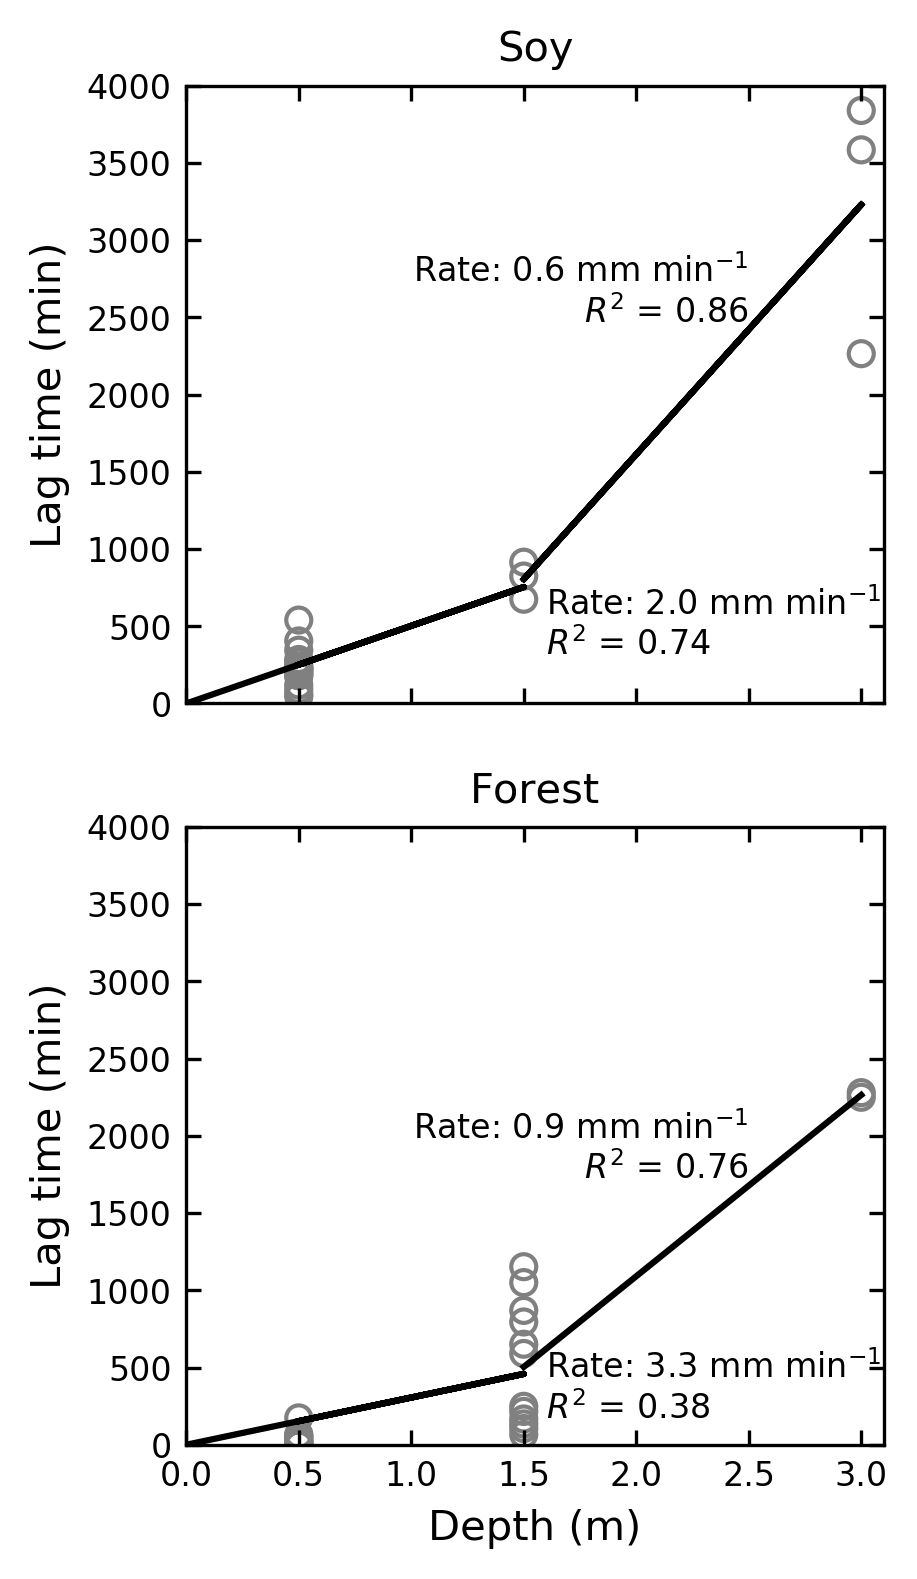

In [74]:
from scipy.optimize import curve_fit

fig, ax = plt.subplots(2,1,figsize=(3,6),dpi=300,sharex=True,sharey=True)

# plot soy
soy = peaks_land.get_group('soy')
x = soy.depth
y = soy.ret_time_min
ax[0].scatter(x=x, y=y, facecolor='', edgecolor='gray')

# plot 0 - 0.5 - 1.5 line
x1 = soy[soy['depth'] != 3.0].depth
y1 = soy[soy['depth'] != 3.0].ret_time_min
def d1(x, a):
    return a*x + 0
popt1, pcov1 = curve_fit(d1, x1, y1)
residuals = y1 - d1(x1, *popt1)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y1-np.mean(y1))**2)
r_squared = 1 - (ss_res / ss_tot)
ax[0].plot(np.append(x1,[0]*len(x1)), d1(np.append(x1,[0]*len(x1)), *popt1), 'k-')
ax[0].annotate('Rate: '+str(round(1/popt1[0]*1000,1))+' mm min$^{-1}$'+'\n$R^2$ = '+str(round(r_squared,2)),
               xy=(1.6,d1(1.5, *popt1)),va='top')

# plot second fit line
x2 = soy[soy['depth'] != 0.5].depth
y2 = soy[soy['depth'] != 0.5].ret_time_min
def d2(x, a, b):
    return a*x + b
popt2, pcov2 = curve_fit(d2, x2, y2)
residuals = y2 - d2(x2, *popt2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y2-np.mean(y2))**2)
r_squared = 1 - (ss_res / ss_tot)
ax[0].plot(x2, d2(x2, *popt2), 'k-')
ax[0].annotate('Rate: '+str(round(1/popt2[0]*1000,1))+' mm min$^{-1}$'+'\n$R^2$ = '+str(round(r_squared,2)),
               xy=(2.5,d2(2.5, *popt2)),va='bottom',ha='right')

ax[0].set_xlim(0.1,3.1)
ax[0].set_ylim(0,4000)
ax[0].tick_params('both',direction='in',right=True, top=True)
ax[0].set_ylabel('Lag time (min)')
ax[0].set_title('Soy')

# ------------------------------------------------
# plot Forest
forest = peaks_land.get_group('forest')
x = forest.depth
y = forest.ret_time_min
ax[1].scatter(x=x, y=y, facecolor='', edgecolor='gray')

# plot first fit line
x1 = forest[forest['depth'] != 3.0].depth
y1 = forest[forest['depth'] != 3.0].ret_time_min
def d1(x, a):
    return a*x + 0
popt1, pcov1 = curve_fit(d1, x1, y1)
residuals = y1 - d1(x1, *popt1)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y1-np.mean(y1))**2)
r_squared = 1 - (ss_res / ss_tot)
ax[1].plot(np.append(x1,[0]*len(x1)), d1(np.append(x1,[0]*len(x1)), *popt1), 'k-')
ax[1].annotate('Rate: '+str(round(1/popt1[0]*1000,1))+' mm min$^{-1}$'+'\n$R^2$ = '+str(round(r_squared,2)),
               xy=(1.6,d1(2, *popt1)),va='top',ha='left')

# plot second fit line
x2 = forest[forest['depth'] != 0.5].depth
y2 = forest[forest['depth'] != 0.5].ret_time_min
def d2(x, a, b):
    return a*x + b
popt2, pcov2 = curve_fit(d2, x2, y2)
residuals = y2 - d2(x2, *popt2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y2-np.mean(y2))**2)
r_squared = 1 - (ss_res / ss_tot)
ax[1].plot(x2, d2(x2, *popt2), 'k-')
ax[1].annotate('Rate: '+str(round(1/popt2[0]*1000,1))+' mm min$^{-1}$'+'\n$R^2$ = '+str(round(r_squared,2)),
               xy=(2.5,d2(2.5, *popt2)),va='bottom',ha='right')

ax[1].tick_params('both',direction='in',right=True, top=True)
ax[1].set_xlabel('Depth (m)')
ax[1].set_ylabel('Lag time (min)')
ax[1].set_title('Forest')
ax[0].set_xlim(0,3.1)
ax[0].set_xticks(np.arange(0,3.5,.5))

fig.patch.set_facecolor('w')

# Ion plots

## Kd plots

### Nitrate

In [6]:
kcl_kd = pd.DataFrame([[0.5,1.121617366,24.62833774,0.677866497,],
              [1.5,6.449966649,4.384346577,25.87725259,1.825989879],
              [3.0,7.186824081,6.816821907,7.365039712,7.483733053]],
             columns=['depth','Ag-1','Fr-1','Fr-2','Ag-2'])


di_kd = pd.DataFrame([[0.5,0.841861085,9.933245129,0.144349888,],
                       [1.5,2.590070532,1.099614338,7.373263365,0.539408482],
                       [3,2.640040813,1.481815489,1.077374618,3.682847256]],
                      columns=['depth','Ag-1','Fr-1','Fr-2','Ag-2'])


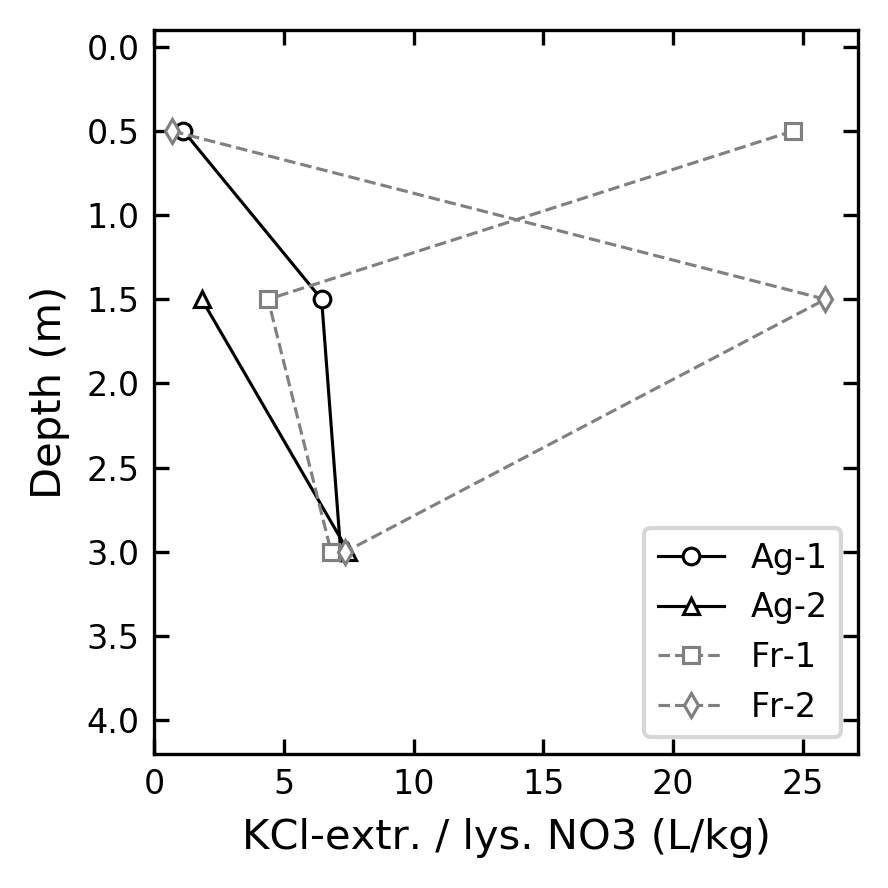

In [18]:
di_group = ion_ext.groupby(['location','depth'])
di_stats = di_group.describe()
kcl_group = ion_kcl.groupby(['location','depth'])
kcl_stats = kcl_group.describe()

fig, ax2 = plt.subplots(1,1,figsize=(3.,3.),sharey=True,dpi=300)

locs = ['AP1','MUT','K1','F1']
name = ['Ag-1','Ag-2','Fr-1','Fr-2']
fmt = ['-o','-^','--s','--d',]
colors = ['k','k','gray','gray']
    
ax2.set_ylim(4.2,-0.1)

for i, l in enumerate(['Ag-1','Ag-2','Fr-1','Fr-2']):
    y = kcl_kd.depth
    x = kcl_kd[l]
    ax2.plot(x,y,fmt[i],color=colors[i],label=l,ms=4,lw=.75,mew=.75)
ax2.legend(ncol=1)
ax2.set_xlabel('KCl-extr. / lys. NO3 (L/kg)')
ax2.set_ylabel('Depth (m)')
ax2.set_xlim(left=0)
ax2.tick_params(direction='in',right=True,top=True)
fig.patch.set_facecolor('w')
fig.tight_layout()

## DI results

In [25]:
locs = ['AP1','MUT','F1','K1']
di_group = ion_ext.groupby(['location','depth'])
di_stats = di_group.describe()
diffs = []
for i,loc in enumerate(locs):
    diff = kcl_stats.loc[loc,'nitrate_mmolkg']['mean'] / di_stats.loc[loc,'nitrate_mmolkg']['mean']
#     print(str(loc), diff)

import itertools
from scipy import stats
solutes = ['nitrate_mM', 'sulfate_mM', 'chloride_mM', 'k_mM']
depths = di_kcl.depth.unique()

pairs = list(itertools.combinations(depths, 2))
p = []
for l in locs:    
    for x in depths:
        test = stats.ttest_ind(
            ion_ext[(ion_ext['depth'] == x) & (ion_ext['location'] == l)]['nitrate_mmolkg'], 
            ion_kcl[(ion_kcl['depth'] == x) & (ion_kcl['location'] == l)]['nitrate_mmolkg'],
            equal_var=False, nan_policy='omit')
                
        mw = stats.mannwhitneyu(
            ion_ext[(ion_ext['depth'] == x) & (ion_ext['location'] == l)]['nitrate_mmolkg'], 
            ion_kcl[(ion_kcl['depth'] == x) & (ion_kcl['location'] == l)]['nitrate_mmolkg'],
            alternative='two-sided')

        p.append([l,x,test[0],test[1],mw[0],mw[1]])

pvals = pd.DataFrame(p,columns=['location','depth (m)','t-stat','p-value','U-stat','p-value'])


,location,depth (m),t-stat,p-value,U-stat,p-value
0,AP1,0.5,-4.320105,0.015806,0.0,0.080856
1,AP1,1.0,-0.899591,0.433144,2.0,0.382733
2,AP1,2.0,-17.033525,0.009530,0.0,0.245278
3,AP1,3.0,-8.525472,0.054130,0.0,0.245278
4,AP1,4.0,-0.616056,0.634190,2.0,0.698535
5,AP1,0.0,-7.213377,0.003202,0.0,0.080856
6,MUT,0.5,-4.720516,0.010317,0.0,0.080856
7,MUT,1.0,-1.242350,0.317024,2.0,0.382733
8,MUT,2.0,-8.178214,0.013757,0.0,0.080856
9,MUT,3.0,-3.541053,0.058260,0.0,0.080856


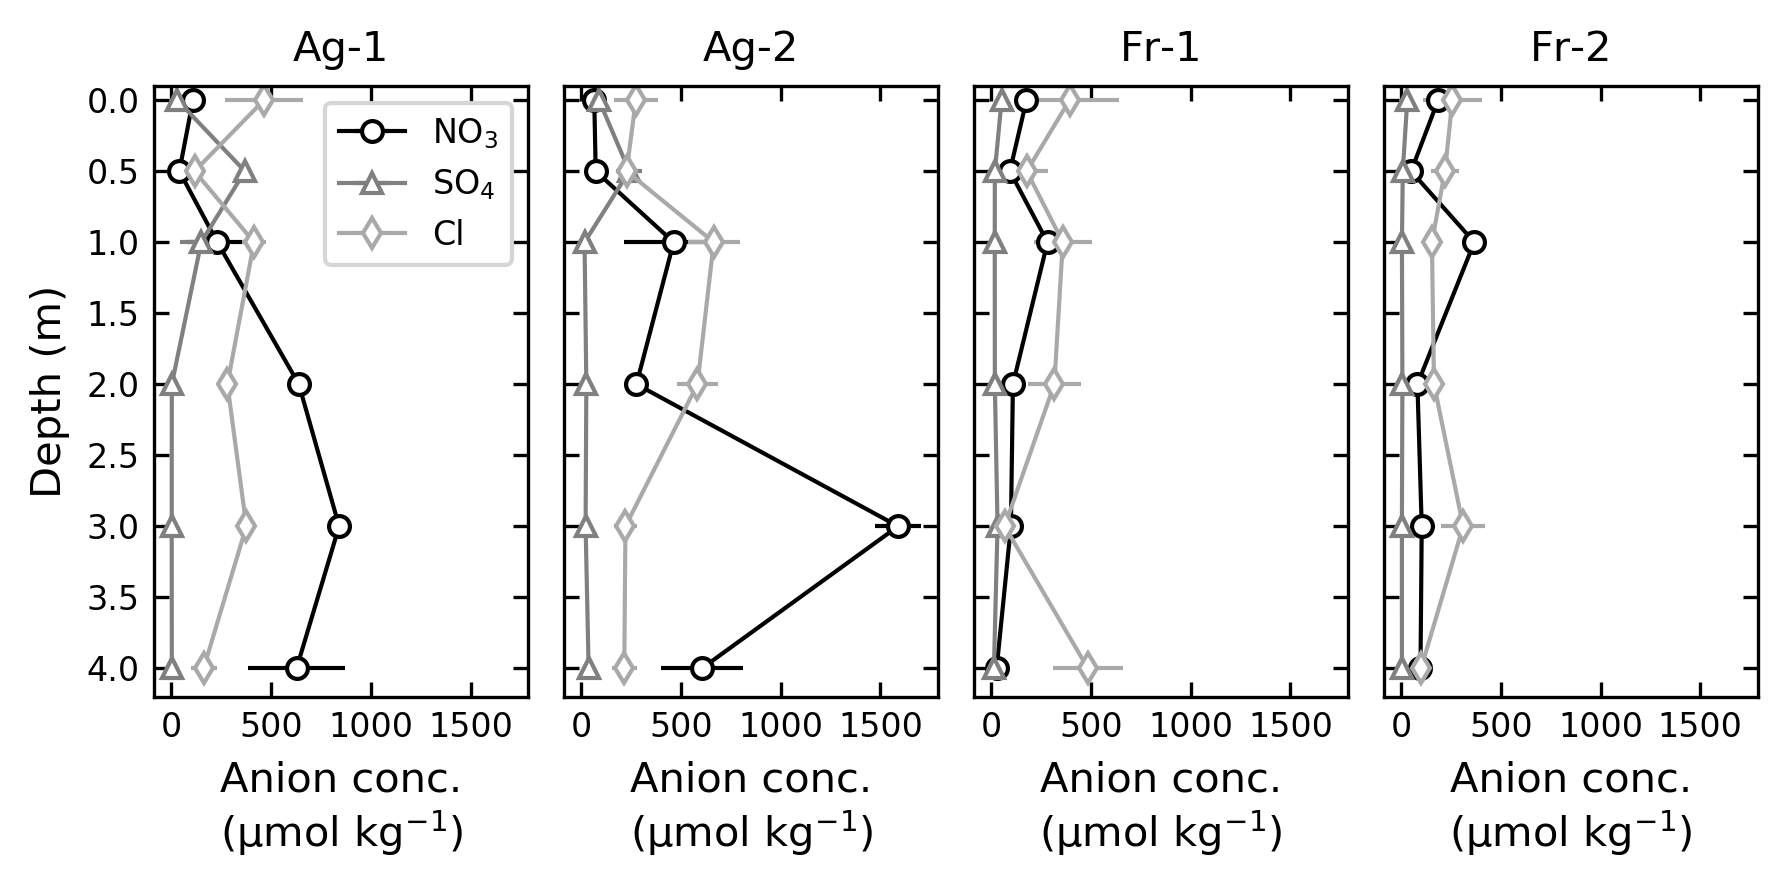

In [127]:
# lys_group = ion_lys[ion_lys['type']=='TEN'].groupby(['location','depth'])
di_group = ion_ext.groupby(['location','depth'])
di_stats = di_group.describe()

fig, ax = plt.subplots(1,4,figsize=(6,3),dpi=300,sharey=True,sharex=True)

locs = ['AP1','MUT','F1','K1']
name = ['Ag-1','Ag-2','Fr-1','Fr-2']
labels = ['$NO_{3}$']
for i,loc in enumerate(locs):
#     x = di_stats.loc[loc,'nitrate_mmolkg']['mean'] * 1000 / di_stats.loc[loc,'nitrate_mmolkg']['mean'] * 1000
#     ax[i].plot()
    x = di_stats.loc[loc,'nitrate_mmolkg']['mean'] * 1000
    y = di_stats.loc[loc,'nitrate_mmolkg']['mean'].index
    e = di_stats.loc[loc,'nitrate_mmolkg']['std']*1000 / np.sqrt(di_stats.loc[loc,'sulfate_mMsoil']['count'])
    ax[i].errorbar(x,y,xerr=e,fmt='-o',c='k',label='NO$_3$',markerfacecolor="w",lw=1,ms=5)
    
    x = di_stats.loc[loc,'sulfate_mmolkg']['mean']*1000
    y = di_stats.loc[loc,'sulfate_mmolkg']['mean'].index
    e = di_stats.loc[loc,'sulfate_mmolkg']['std']*1000 / np.sqrt(di_stats.loc[loc,'sulfate_mMsoil']['count'])
    ax[i].errorbar(x,y,xerr=e,fmt='-^',c='gray',label='SO$_4$',markerfacecolor="w",lw=1,ms=5)
    
    x = di_stats.loc[loc,'chloride_mmolkg']['mean'] * 1000
    y = di_stats.loc[loc,'chloride_mmolkg']['mean'].index
    e = di_stats.loc[loc,'chloride_mmolkg']['std']*1000 / np.sqrt(di_stats.loc[loc,'sulfate_mMsoil']['count'])
    ax[i].errorbar(x,y,xerr=e,fmt='-d',c='darkgray',label='Cl',markerfacecolor="w",lw=1,ms=5)
    
    


    ax[i].set_title(name[i])
    ax[i].set_xlabel('Anion conc.\n(μmol kg$^{-1}$)')
    ax[i].set_xticks(np.arange(0,2000,500))
#     ax[i].set_xscale('log')
    ax[i].tick_params(direction='in',right=True,top=True)
ax[0].legend()
ax[0].set_ylim(4.2,-0.1)
ax[0].set_ylabel('Depth (m)')
# ax[0].set_xlim(0.1,100)

fig.patch.set_facecolor('w')
fig.tight_layout()
# fig.savefig(r'C:\Users\Kalle Jahn\Box Sync\Brazil\Figures\lysimeter_plots\sulfate-aqueous-lysimeter.png')

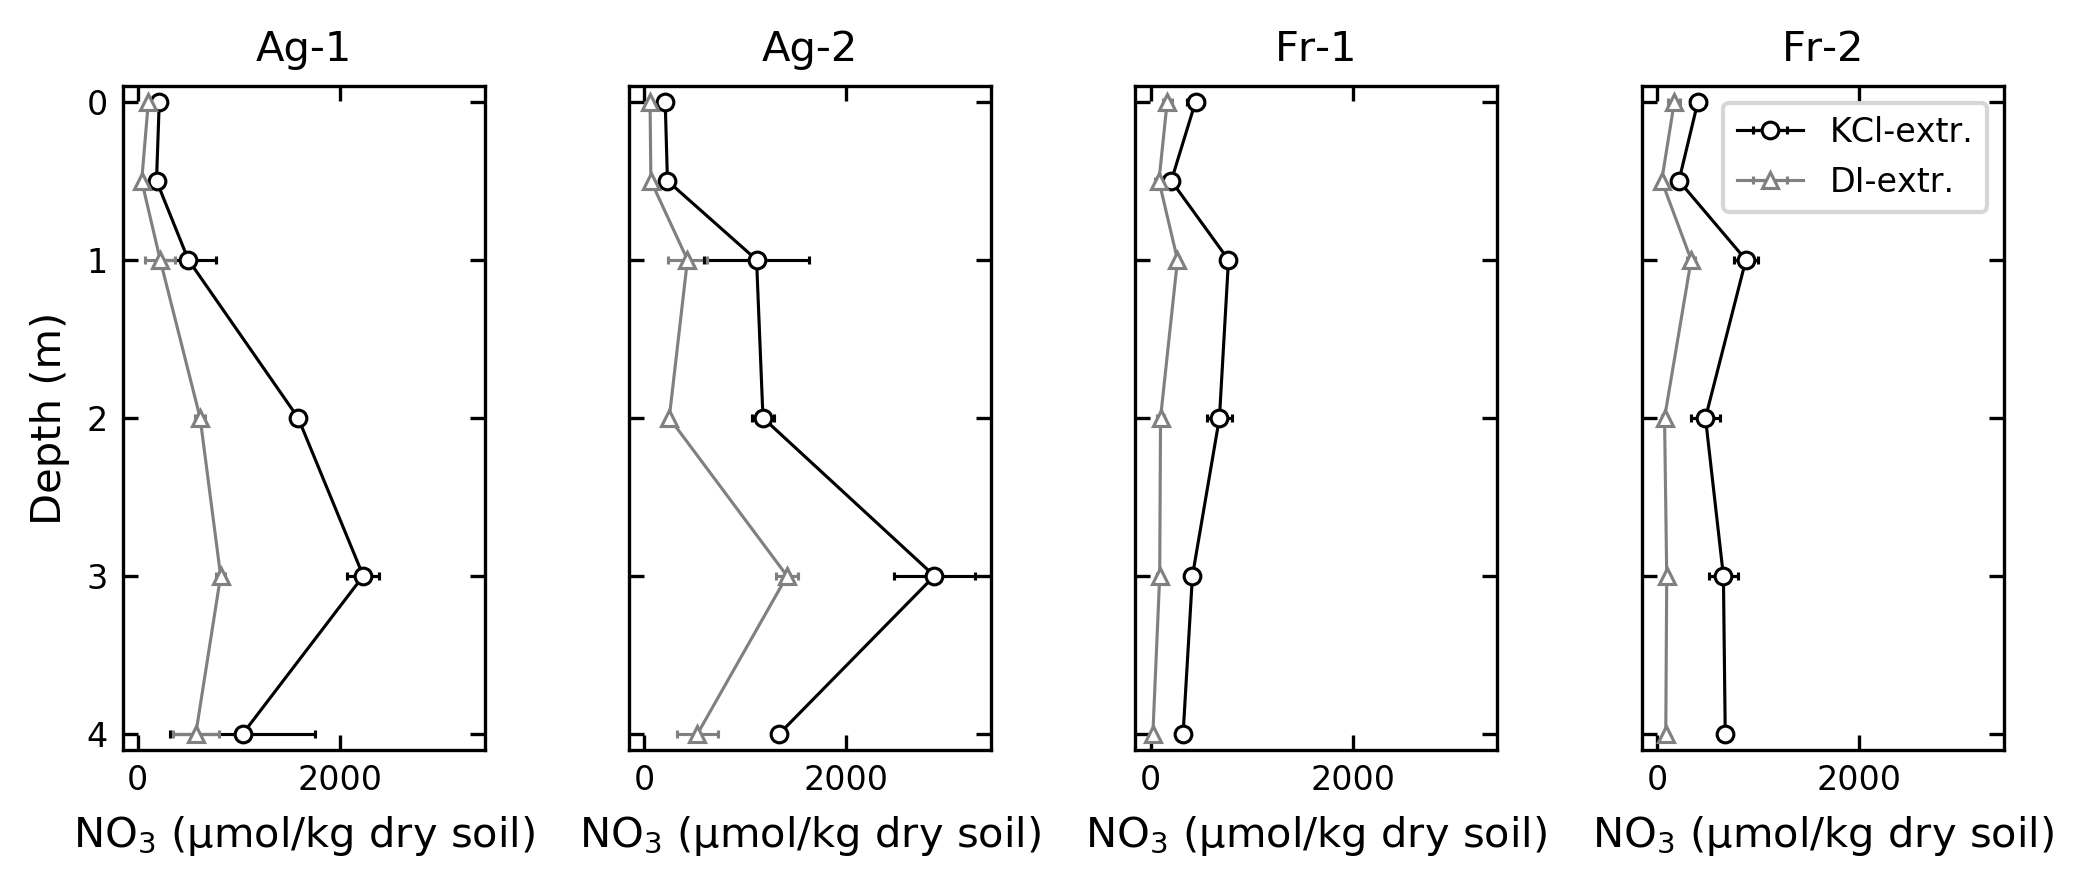

In [448]:
lys_group = ion_lys.groupby(['location','depth'])
lys_stats = lys_group.describe()

kcl_group = ion_kcl.groupby(['location','depth'])
kcl_stats = kcl_group.describe()

fig, ax = plt.subplots(1,4,figsize=(6,3),sharey=True,sharex=True,dpi=300)

locs = ['AP1','MUT','F1','K1']
name = ['Ag-1','Ag-2','Fr-1','Fr-2']

# set colormap
start = 0
stop = .8
number_of_lines= 3
cm_subsection = linspace(start, stop, number_of_lines) 
cmap = plt.cm.get_cmap("plasma")
colors = [ cmap(x) for x in cm_subsection ]
lw=.75

for i,loc in enumerate(locs):
    
    x = kcl_stats.loc[loc,'nitrate_mmolkg']['mean']*1000# - di_stats.loc[loc,'nitrate_mmolkg']['mean']
    y = kcl_stats.loc[loc,'nitrate_mmolkg']['mean'].index
    e = kcl_stats.loc[loc,'nitrate_mmolkg']['std']*1000 / np.sqrt(kcl_stats.loc[loc,'nitrate_mmolkg']['count'])
    ax[i].errorbar(x,y,xerr=e,fmt='-o', capsize=1,markersize=4, mew=lw, lw=lw, markerfacecolor="w",color='k', label = 'KCl-extr.')
    
    x = di_stats.loc[loc,'nitrate_mmolkg']['mean']*1000
    y = di_stats.loc[loc,'nitrate_mmolkg']['mean'].index
    e = di_stats.loc[loc,'nitrate_mmolkg']['std']*1000 / np.sqrt(di_stats.loc[loc,'nitrate_mmolkg']['count'])
    ax[i].errorbar(x,y,xerr=e,fmt='-^', capsize=1,markersize=4, mew=lw, lw=lw, markerfacecolor="w",color='gray',label='DI-extr.')
    
#     x = lys_stats.loc[loc,'nitrate_mmolkg']['mean']*1000
#     y = lys_stats.loc[loc,'nitrate_mmolkg']['mean'].index
#     e = lys_stats.loc[loc,'nitrate_mmolkg']['std']*1000 / np.sqrt(lys_stats.loc[loc,'nitrate_mmolkg']['count'])
#     ax[i].errorbar(x,y,xerr=e,fmt='--s', capsize=1,markersize=4, mew=lw, lw=lw,markerfacecolor="w",color='darkgray',label='Lys. water')
    
    ax[i].set_title(name[i])
    ax[i].tick_params(direction='in',top=True,right=True)
    ax[i].set_xlabel('NO$_{3}\n(μmol/kg dry soil)')
# ax[0].set_xlim(left=-100)
ax[0].set_yticks(range(0,5,1))
ax[0].set_ylim(4.1,-0.1)
ax[0].set_ylabel('Depth (m)')
ax[3].legend()

fig.patch.set_facecolor('w')
fig.tight_layout()
# fig.savefig(r'C:\Users\Kalle Jahn\Box Sync\Brazil\Figures\lysimeter_plots\sulfate-aqueous-lysimeter.png')

## Lysimeter results

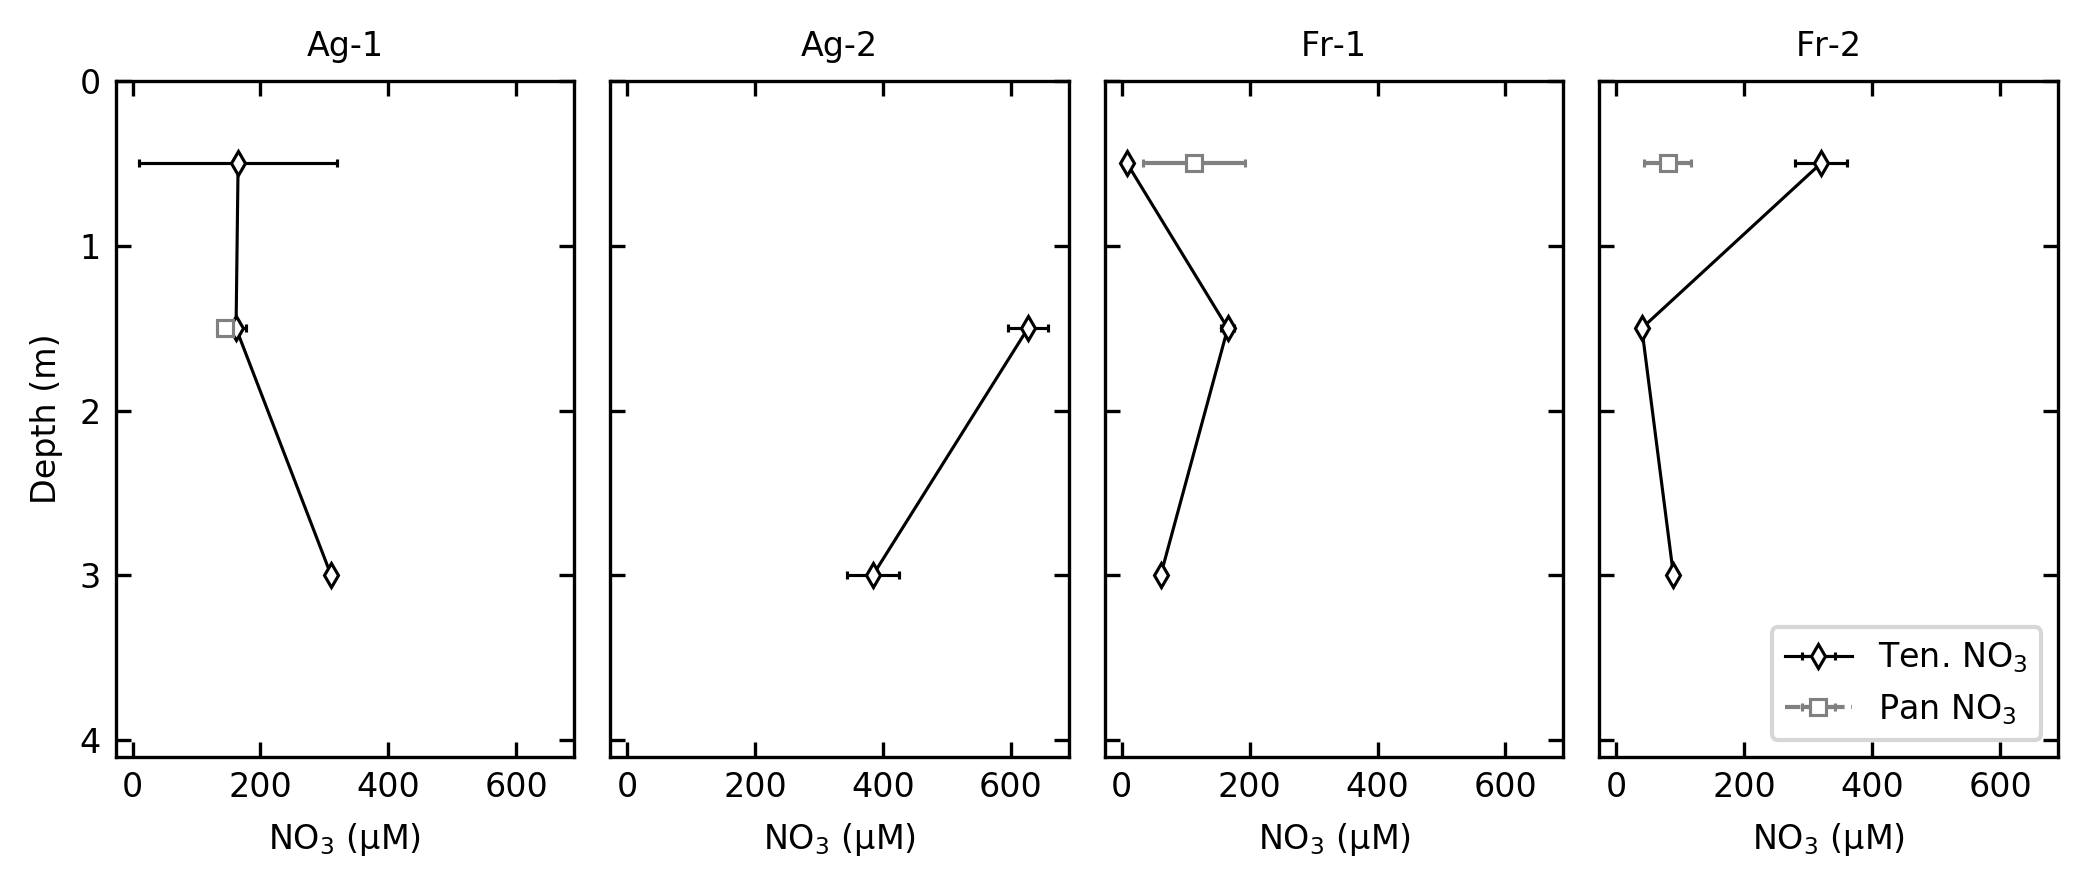

In [91]:
lys_group = ion_lys.groupby(['location','depth'])
lys_stats = lys_group.describe()

pan_group = ion_lys_pan.groupby(['location','depth'])
pan_stats = pan_group.describe()

fig, ax = plt.subplots(1,4,figsize=(6,3),sharey=True,sharex=True,dpi=300)

locs = ['AP1','MUT','F1','K1']
name = ['Ag-1','Ag-2','Fr-1','Fr-2']
labels = ['$NO_{3}$']

# set colormap
start = 0
stop = .8
number_of_lines= 6
cm_subsection = linspace(start, stop, number_of_lines) 
cmap = plt.cm.get_cmap("Dark2")
colors = [ cmap(x) for x in cm_subsection ]

for i,loc in enumerate(locs):
    x = lys_stats.loc[loc,'nitrate_mM']['mean']*1000
    y = lys_stats.loc[loc,'nitrate_mM']['mean'].index
    e = lys_stats.loc[loc,'nitrate_mM']['std']*1000 / np.sqrt(lys_stats.loc[loc,'nitrate_mM']['count'])
    ax[i].errorbar(x,y,xerr=e,fmt='-d',label='Ten. NO$_3$',capsize=1,markersize=4,markerfacecolor="w",color='k',mew=.75,lw=.75)
    try:
        x = pan_stats.loc[loc,'nitrate_mM']['mean']*1000
        y = pan_stats.loc[loc,'nitrate_mM']['mean'].index
        e = pan_stats.loc[loc,'nitrate_mM']['std']*1000 / np.sqrt(pan_stats.loc[loc,'nitrate_mM']['count'])
        ax[i].errorbar(x,y,xerr=e,fmt='--s',label='Pan NO$_3$',capsize=1,markersize=4,lw=1,mew=.75,
                       markerfacecolor="w",color='gray')
    except:
        pass

    ax[i].set_title(name[i])
    ax[i].tick_params(direction='in',top=True,right=True)
    ax[i].set_xlabel('Leaching water\nconcentration (μM)')
    ax[i].set_xlabel('NO$_3$ (μM)')
    
ax[3].legend(loc='lower right')
ax[0].set_ylim(4.1,0)
ax[0].set_ylabel('Depth (m)')
ax[0].set_yticks(range(0,5,1))

fig.patch.set_facecolor('w')
fig.tight_layout()


## KCl results

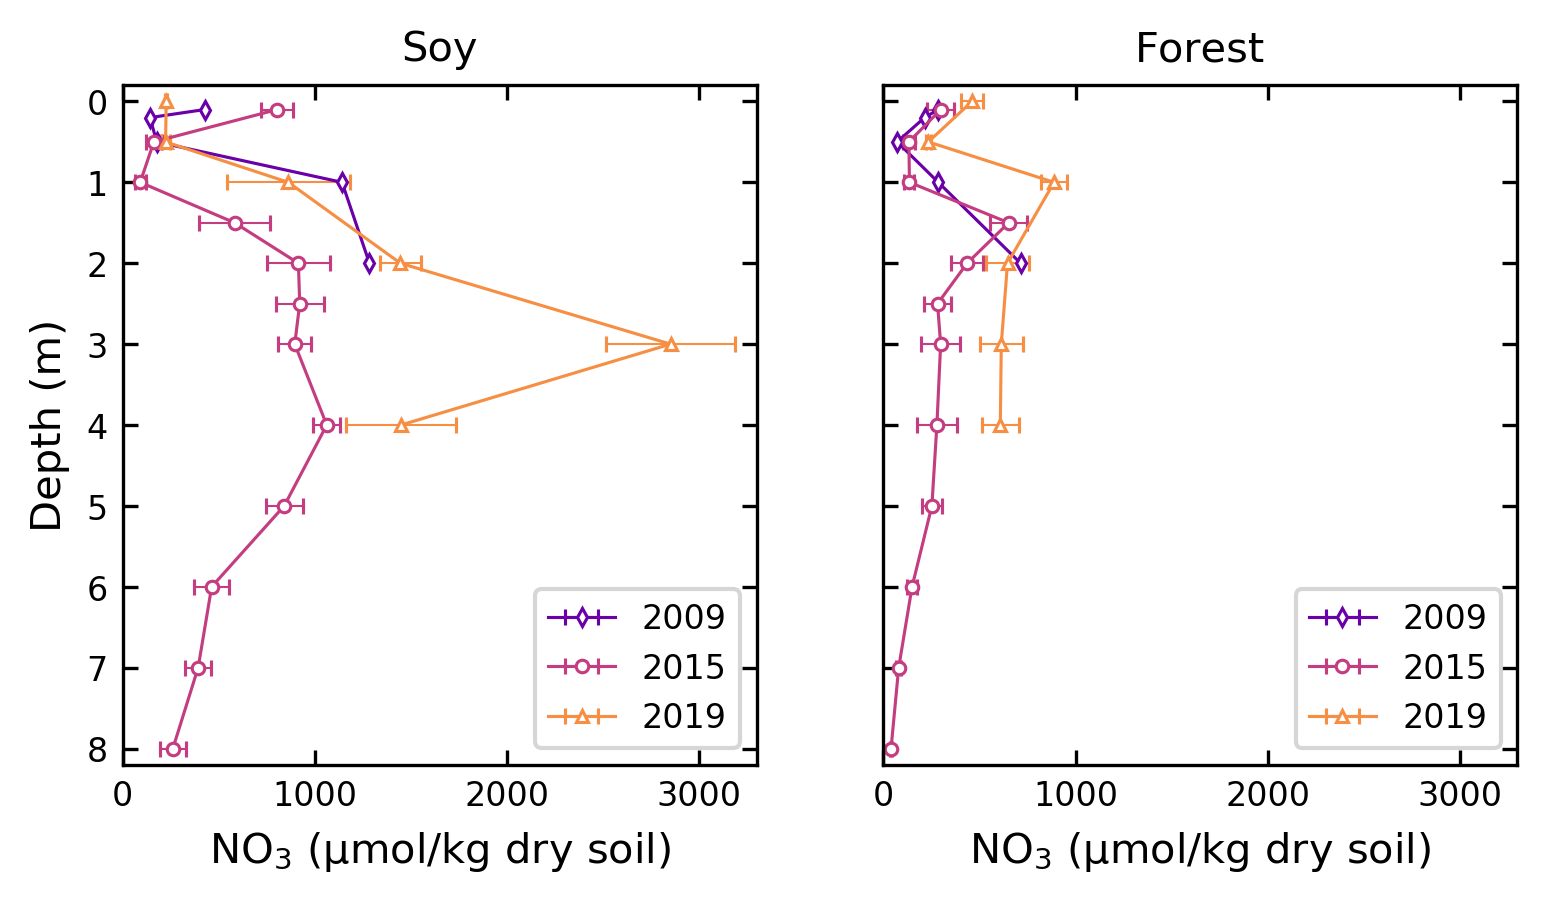

In [22]:
kcl_group = ion_kcl.groupby(['landuse','depth'])
kcl_stats = kcl_group.describe()


fig, ax = plt.subplots(1,2,figsize=(6,3),dpi=300,sharey=True,sharex=True)

# set colormap
start = .2
stop = 1
number_of_lines= 4
cm_subsection = linspace(start, stop, number_of_lines) 
cmap = plt.cm.get_cmap("plasma")
colors = [ cmap(x) for x in cm_subsection]

locs = ['forest2009','forest','forest']
name = ['2009','2015','2019']

fmt = ['d-','o-','^-','o-']
for i, lu in enumerate(locs):
    if i == 0:
        df = fa_kcl_stats.loc[lu]
    elif i == 1:
        df = kj_kcl_stats.loc[lu]
    else:
        df = kcl_stats.loc[lu]
    xerr = df['nitrate_mmolkg']['std']*1000 / np.sqrt(df['nitrate_mmolkg']['count'])
    ax[1].errorbar(x=df['nitrate_mmolkg']['mean']*1000,y=df.index,xerr=xerr, # multiplying by 1000 to get umol/kg
                   fmt=fmt[i],linewidth=.75,elinewidth=0.5,capsize=2,label=name[i],
                   color=colors[i],markerfacecolor="w",mew=.75,ms=3)

# set colormap
start = .2
stop = 1
number_of_lines= 4
cm_subsection = linspace(start, stop, number_of_lines) 
cmap = plt.cm.get_cmap("plasma")
colors = [ cmap(x) for x in cm_subsection]

locs = ['soybean2009','soybean','soybean']
name = ['2009','2015','2019']
fmt = ['d-','o-','^-','o-']
for i, lu in enumerate(locs):
    if i == 0:
        df = fa_kcl_stats.loc[lu]
    elif i == 1:
        df = kj_kcl_stats.loc[lu]
    else:
        df = kcl_stats.loc[lu]
    
    xerr = df['nitrate_mmolkg']['std']*1000 / np.sqrt(df['nitrate_mmolkg']['count'])
    ax[0].errorbar(x=df['nitrate_mmolkg']['mean']*1000,y=df.index,xerr=xerr,
                   fmt=fmt[i],linewidth=.75,elinewidth=0.5,capsize=2,label=name[i],
                   color=colors[i],markerfacecolor="w",mew=.75,ms=3)
    
ax[0].set_ylim(8.2,-0.2)
ax[0].set_xlim(0,3300.)
ax[0].set_ylabel('Depth (m)')
for x in ax:
    x.legend(loc='lower right')
    x.tick_params(axis='both',which='both',direction='in',right=True,top=True)
    x.set_xlabel('NO$_3$ (μmol/kg dry soil)')
    
ax[1].set_title('Forest')
ax[0].set_title('Soy')

fig.tight_layout
fig.patch.set_facecolor('w')

## calculating total NO3 mass

In [135]:
bds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['mean']
bds_stds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['std']
bds_stds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['std']
kj_nitrate = kj_kcl_stats.ugNO3gds.loc['soybean'].iloc[:8,:]
depths = [0.1,0.5,1.0,1.5,2.0,2.5,3.0,4.0]
thicknesses = [0.25,0.5,0.5,0.5,0.5,0.5,1.,1.]


# convert mg N / kg soil to kg N / kg soil
kj_nitrate = kj_nitrate / 1000000

# convert kg N / kg soil to kg N / m3 using bulk density averages
kj_nitrate = kj_nitrate * bds.max()
#     kj_nitrate.loc[[l]] = kj_nitrate.loc[[l]] * (bds[l]-bds_stds[l])
#     kj_nitrate_m.loc[[l]] = kj_nitrate_m.loc[[l]] * (bds[l]-bds_stds[l])

# convert kg N / m3 to kg N / hectare*m
kj_nitrate = kj_nitrate * 10000
# multiply each element of the profile by the depth it represents to get just hectares
for d, t in zip(depths, thicknesses):
    kj_nitrate.loc[d] = kj_nitrate.loc[d] * t
# convert hectare*m 

print(kj_nitrate['mean'].sum())

788.4231034697243


In [150]:
bds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['mean']
bds_stds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['std']
bds_min = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['min']
depths = [0.0,0.5,1.0,2.0,3.0,4.0]
thicknesses = [0.25,0.5,0.75,1.,1.,1.]
kcl_nitrate = kcl_stats['nitrate-n_mgkg'].iloc[:,1:]

# convert mg N / kg soil to kg N / kg soil
kcl_nitrate = kcl_nitrate / 1000000

# convert kg N / kg soil to kg N / m3 using bulk density averages
for l in bds.index:
#     kcl_nitrate.loc[[l]] = kcl_nitrate.loc[[l]] * bds[l]
    kcl_nitrate.loc[[l]] = kcl_nitrate.loc[[l]] * (bds_min[l])

# convert kg N / m3 to kg N / hectare*m
kcl_nitrate = kcl_nitrate * 10000
# multiply each element of the profile by the depth it represents to get just hectares
for l in bds.index:
    for d, t in zip(depths, thicknesses):
        kcl_nitrate.loc[l,d] = kcl_nitrate.loc[l,d] * t
# convert hectare*m 

print(kcl_nitrate.loc['AP1']['mean'].sum())
print(kcl_nitrate.loc['MUT']['mean'].sum())

print(kcl_nitrate.loc['F1']['mean'].sum())
print(kcl_nitrate.loc['K1']['mean'].sum())

1184.931443147391
1126.6308350235788
418.18369362502443
510.0778470285842


In [126]:
bds = bulk_den.groupby('Loc').describe()['dry_bulk_kgm3']['mean']
depths = [0.0,0.5,1.0,2.0,3.0,4.0]
thicknesses = [0.25,0.5,0.75,1.,1.,1.]
kcl_nitrate = kcl_stats['nitrate_mmolkg'].iloc[:,1:]

# convert mmol NO3 / kg soil to mol NO3 / kg soil
kcl_nitrate = kcl_nitrate / 1000
# convert mol/kg to g N / kg soil
kcl_nitrate = kcl_nitrate * 14.0067
# conver g N / kg soil to kg N / kg soil
kcl_nitrate = kcl_nitrate / 1000

# convert kg N / kg soil to kg N / m3 using bulk density averages
for l in bds.index:
    kcl_nitrate.loc[[l]] = kcl_nitrate.loc[[l]] * bds[l]

# convert kg N / m3 to kg N / hectare*m
kcl_nitrate = kcl_nitrate * 10000
# multiply each element of the profile by the depth it represents to get just hectares
for l in bds.index:
    for d, t in zip(depths, thicknesses):
        kcl_nitrate.loc[l,d] = kcl_nitrate.loc[l,d] * t
# convert hectare*m 

print(kcl_nitrate.loc['AP1']['mean'].sum())
print(kcl_nitrate.loc['MUT']['mean'].sum())

print(kcl_nitrate.loc['F1']['mean'].sum())
print(kcl_nitrate.loc['K1']['mean'].sum())

1268.0306484694665
1142.7313687585306
472.70707889968696
524.4837532286016


In [311]:
bds = {'AP1':1.61,'MUT':1.38,'F1':1.27,'K1':1.12}
di_nitrate = di_stats['nitrate_mmolkg'].iloc[:,1:]

# convert mmmol/kg soil to kg N / kg soil

di_nitrate = di_nitrate * 14 / 10**6

# convert kg N / kg soil to kg N / m3 using bulk density averages
for l in bds:
    di_nitrate.loc[[l]] = di_nitrate.loc[[l]] * bds[l]

# convert m3 to hectare*m
di_nitrate = di_nitrate * 10000

di_nitrate.loc[['AP1']].sum()

mean    0.535518
std     0.172907
min     0.416064
25%     0.458956
50%     0.501848
75%     0.595245
max     0.688641
dtype: float64

In [151]:
# bds = {'AP1':1.61,'MUT':1.38,'F1':1.27,'K1':1.12} # g/cm3
bds = {'AP1':1610,'MUT':1380,'F1':1270,'K1':1120} # kg/m3
depths = [0.0,0.5,1.0,2.0,3.0,4.0]
thicknesses = [0.25,0.5,0.75,1.,1.,1.]
di_nitrate = di_stats['nitrate_mmolkg'].iloc[:,1:]

# convert mmol NO3 / kg soil to mol NO3 / kg soil
di_nitrate = di_nitrate / 1000
# convert mol/kg to g N / kg soil
di_nitrate = di_nitrate * 14.0067
# conver g N / kg soil to kg N / kg soil
di_nitrate = di_nitrate / 1000

# convert kg N / kg soil to kg N / m3 using bulk density averages
for l in bds:
    di_nitrate.loc[[l]] = di_nitrate.loc[[l]] * bds[l]

# convert kg N / m3 to kg N / hectare*m
di_nitrate = di_nitrate * 10000
# multiply each element of the profile by the depth it represents to get just hectares
for l in bds:
    for d, t in zip(depths, thicknesses):
        di_nitrate.loc[l,d] = di_nitrate.loc[l,d] * t
# convert hectare*m 

print(di_nitrate.loc['AP1']['mean'].sum())
print(di_nitrate.loc['MUT']['mean'].sum())

501.3073322008436
494.5106034691349


## Lysimeter Nitrate time series

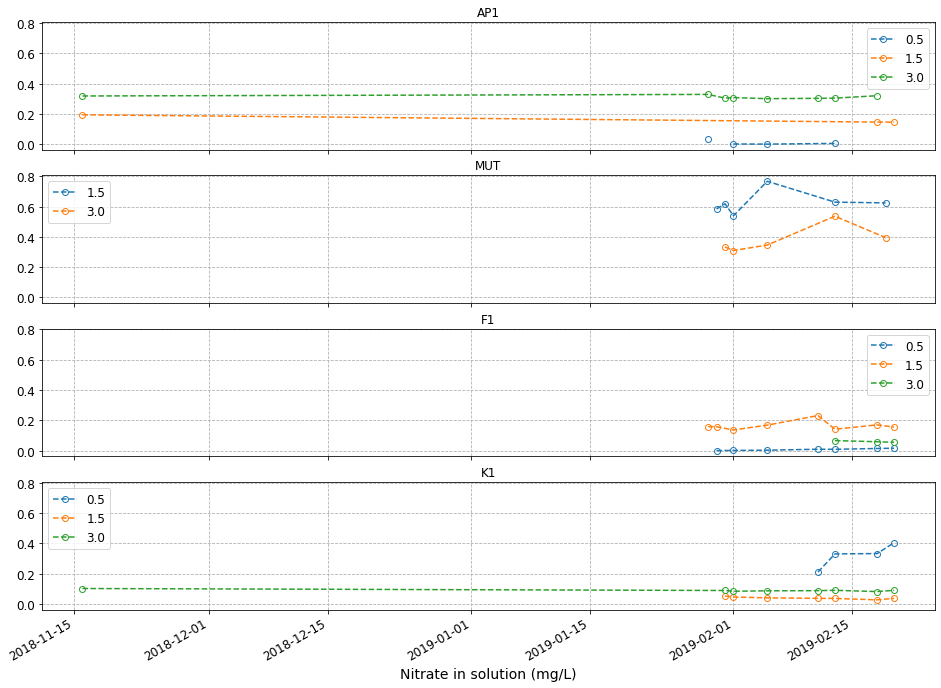

In [34]:
lys_group = ion_lys[ion_lys['type']=='TEN'].groupby(['location','depth'])
pan_group = ion_lys[ion_lys['type']=='PAN'].groupby(['location','depth'])

fig, ax = plt.subplots(4,1,figsize=(16,12),sharex=True,sharey=True)

for g in lys_group:
    loc = g[0][0]
    if loc == 'AP1':
        ax[0].plot(g[1].date,g[1].nitrate_mM,'--o',label=g[0][1],markerfacecolor='None')
        ax[0].set_title(loc)
    if loc == 'MUT':
        ax[1].plot(g[1].date,g[1].nitrate_mM,'--o',label=g[0][1],markerfacecolor='None')
        ax[1].set_title(loc)
    if loc == 'F1':
        ax[2].plot(g[1].date,g[1].nitrate_mM,'--o',label=g[0][1],markerfacecolor='None')
        ax[2].set_title(loc)
    if loc == 'K1':
        ax[3].plot(g[1].date,g[1].nitrate_mM,'--o',label=g[0][1],markerfacecolor='None')
        ax[3].set_title(loc)
        
for g in pan_group:
    loc = g[0][0]
    if loc == 'AP1':
        ax[0].plot(g[1].date,g[1].nitrate_mM,'x',label=g[0][1])
        ax[0].set_title(loc)
    if loc == 'MUT':
        ax[1].plot(g[1].date,g[1].nitrate_mM,'x',label=g[0][1])
        ax[1].set_title(loc)
    if loc == 'F1':
        ax[2].plot(g[1].date,g[1].nitrate_mM,'x',label=g[0][1])
        ax[2].set_title(loc)
    if loc == 'K1':
        ax[3].plot(g[1].date,g[1].nitrate_mM,'x',label=g[0][1])
        ax[3].set_title(loc)

for i in range(4):
    ax[i].legend()
    ax[i].grid(which='both',ls='--')
    ax[i].set_xlabel('Nitrate in solution (mg/L)')
    plt.gcf().autofmt_xdate()
    ax[i].xaxis.set_major_locator(mdates.DayLocator([1,15]))
# ax.set_yscale('log')

fig.patch.set_facecolor('w')
# fig.savefig(r'C:\Users\Kalle Jahn\Box Sync\Brazil\Figures\lysimeter_plots\2019_lysimeter_nitrate_time_series.png',dpi=300)

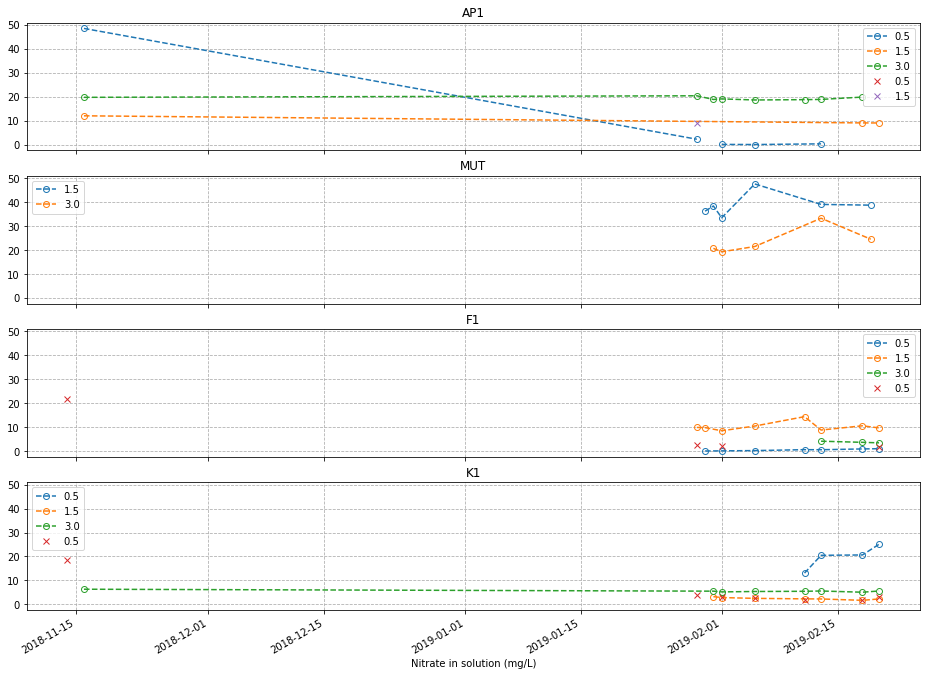

In [21]:
lys_group = ion_lys[ion_lys['type']=='TEN'].groupby(['location','depth'])
pan_group = ion_lys[ion_lys['type']=='PAN'].groupby(['location','depth'])

fig, ax = plt.subplots(4,1,figsize=(16,12),sharex=True,sharey=True)

for g in lys_group:
    loc = g[0][0]
    if loc == 'AP1':
        ax[0].plot(g[1].date,g[1].nitrate_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[0].set_title(loc)
    if loc == 'MUT':
        ax[1].plot(g[1].date,g[1].nitrate_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[1].set_title(loc)
    if loc == 'F1':
        ax[2].plot(g[1].date,g[1].nitrate_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[2].set_title(loc)
    if loc == 'K1':
        ax[3].plot(g[1].date,g[1].nitrate_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[3].set_title(loc)
        
for g in pan_group:
    loc = g[0][0]
    if loc == 'AP1':
        ax[0].plot(g[1].date,g[1].nitrate_ppm,'x',label=g[0][1])
        ax[0].set_title(loc)
    if loc == 'MUT':
        ax[1].plot(g[1].date,g[1].nitrate_ppm,'x',label=g[0][1])
        ax[1].set_title(loc)
    if loc == 'F1':
        ax[2].plot(g[1].date,g[1].nitrate_ppm,'x',label=g[0][1])
        ax[2].set_title(loc)
    if loc == 'K1':
        ax[3].plot(g[1].date,g[1].nitrate_ppm,'x',label=g[0][1])
        ax[3].set_title(loc)

for i in range(4):
    ax[i].legend()
    ax[i].grid(which='both',ls='--')
    ax[i].set_xlabel('Nitrate in solution (mg/L)')
    plt.gcf().autofmt_xdate()
    ax[i].xaxis.set_major_locator(mdates.DayLocator([1,15]))
# ax.set_yscale('log')

fig.patch.set_facecolor('w')
fig.savefig(r'C:\Users\Kalle Jahn\Box Sync\Brazil\Figures\lysimeter_plots\2019_lysimeter_nitrate_time_series.png')

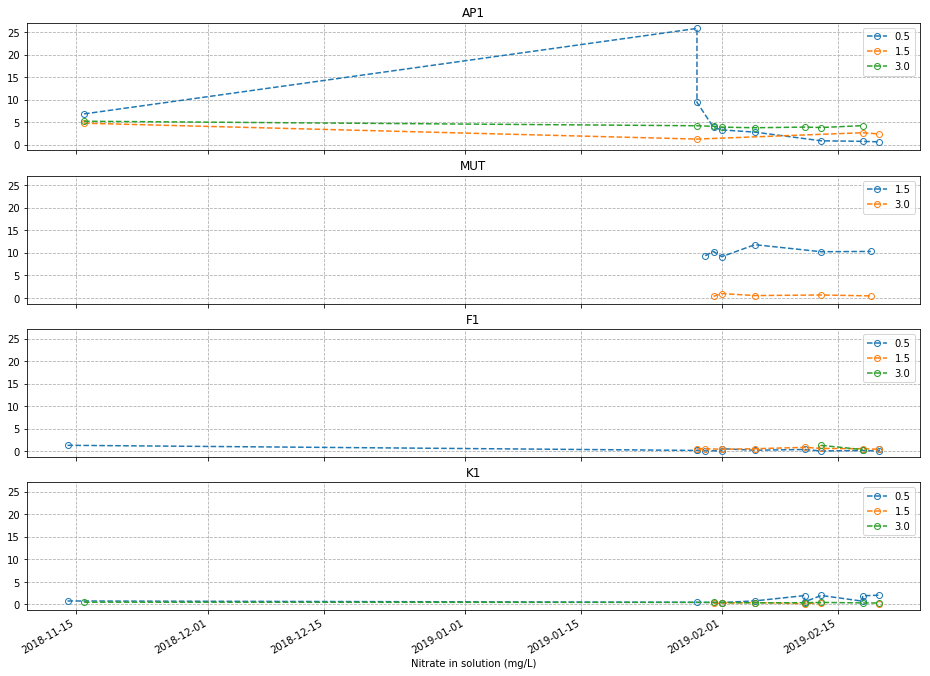

In [242]:
lys_group = ion_lys.groupby(['location','depth'])

fig, ax = plt.subplots(4,1,figsize=(16,12),sharex=True,sharey=True)

for g in lys_group:
    loc = g[0][0]
    if loc == 'AP1':
        ax[0].plot(g[1].date,g[1].chloride_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[0].set_title(loc)
    if loc == 'MUT':
        ax[1].plot(g[1].date,g[1].chloride_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[1].set_title(loc)
    if loc == 'F1':
        ax[2].plot(g[1].date,g[1].chloride_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[2].set_title(loc)
    if loc == 'K1':
        ax[3].plot(g[1].date,g[1].chloride_ppm,'--o',label=g[0][1],markerfacecolor='None')
        ax[3].set_title(loc)

for i in range(4):
    ax[i].legend()
    ax[i].grid(which='both',ls='--')
    ax[i].set_xlabel('Nitrate in solution (mg/L)')
    plt.gcf().autofmt_xdate()
    ax[i].xaxis.set_major_locator(mdates.DayLocator([1,15]))
# ax.set_yscale('log')

fig.patch.set_facecolor('w')
# fig.savefig(r'C:\Users\Kalle Jahn\Box Sync\Brazil\Figures\lysimeter_plots\lysimeter_nitrate_time_series.pdf')

In [ ]:
ext_group = ion_ext.groupby(['location'])

fig, ax = plt.subplots(1,4,figsize=(16,6),sharex=True,sharey=True)

for g in ext_group:
    loc = g[0]
#     ax.scatter(g[1].nitrate_ppm,g[1].depth,label=loc)
    
    if loc == 'AP1':
        ax[0].plot(g[1].nitrate_mgkg,g[1].depth,'o',markerfacecolor="None")
        ax[0].set_title(loc)
    if loc == 'MUT':
        ax[1].plot(g[1].nitrate_mgkg,g[1].depth,'o',markerfacecolor="None")
        ax[1].set_title(loc)
    if loc == 'F1':
        ax[2].plot(g[1].nitrate_mgkg,g[1].depth,'o',markerfacecolor="None")
        ax[2].set_title(loc)
    if loc == 'K1':
        ax[3].plot(g[1].nitrate_mgkg,g[1].depth,'o',markerfacecolor="None")
        ax[3].set_title(loc)

        
ax[0].set_ylim(4.2,0)
ax[0].set_xlim(-2,57)
ax[0].set_ylabel('Depth (m)')
fig.text(0.5, 0.05, 'DI extractable N0$_3$-N (mg / kg dry soil)', fontsize=10, ha='center', rotation='horizontal')

for i in range(4):
#     ax[i].legend()
    ax[i].grid(which='both',ls='--')

# Watershed Scale Comparisons

## Between ag and forest samples

In [149]:
import itertools
from scipy import stats
# solutes = ['NO3_mM', 'SO4_mM', 'Cl_mM', 'K_mM']
solutes = 
locs = tidy.location.unique()
types = ['SW','GW','LW','AEsoil']
pairs = list(itertools.combinations(locs, 2))
p = []MultiComparison
for s in solutes:
    for t in types:    
        for x in pairs:
            test = stats.ttest_ind(
                tidy[(tidy['location'] == x[0]) & (tidy['type'] == t)][s], 
                tidy[(tidy['location'] == x[1]) & (tidy['type'] == t)][s],
                equal_var=False, nan_policy='omit')
            
            p.append([s,t,x[0],x[1],test[0],test[1]])

pvals = pd.DataFrame(p,columns=['solute','type','loc1','loc2','t-stat','pval'])
pvals.dropna().to_excel(r'.\watershed_location_pvals.xlsx')

## Between water sample types

Run (parametric) Welch's unequal variances t-test and ANOVA, and (non-parametric) Mann-Whitney and Kurskal-Wallis

In [135]:
import itertools
from scipy import stats
# solutes = ['NO3_mM', 'SO4_mM', 'Cl_mM', 'K_mM']
s = 'NO3_uM'
# order = ['SW','GW','LW','AEsoil','AEsoil_red']
locations = tidy.location.unique()
order = ['LW-0.5','LW-1.5','LW-3.0','GW1','GW2','GW3','SW']
pairs = list(itertools.combinations(order, 2))
p = []
for l in locations:
    for x in pairs:
        test = stats.ttest_ind(tidy[(tidy['kind'] == x[0]) & (tidy['location'] == l)][s], 
                               tidy[(tidy['kind'] == x[1]) & (tidy['location'] == l)][s],
                               equal_var=False, nan_policy='omit')
        
        mw = stats.mannwhitneyu(tidy[(tidy['kind'] == x[0]) & (tidy['location'] == l)][s],
                                tidy[(tidy['kind'] == x[1]) & (tidy['location'] == l)][s],
                                 alternative='two-sided')
        
        kru = stats.kruskal(tidy[(tidy['kind'] == x[0]) & (tidy['location'] == l)][s],
                            tidy[(tidy['kind'] == x[1]) & (tidy['location'] == l)][s],
                            nan_policy='omit')   
        
        p.append([s,l,x[0],x[1],test[0],test[1],mw[0],mw[1],kru[0],kru[1]])

pvals = pd.DataFrame(p,columns=['solute','location','type1','type2','t-stat','ttest_pval','U-stat','MW_pval','H-stat','K_pval'])
pvals
pvals.to_excel(r'.\water_type_pvals3.xlsx')

In [138]:
import itertools
from scipy import stats
# solutes = ['NO3_mM', 'SO4_mM', 'Cl_mM', 'K_mM']
s = 'NO3_uM'
# order = ['SW','GW','LW','AEsoil','AEsoil_red']
locations = tidy.location.unique()
order = ['LW-0.5','LW-1.5','LW-3.0','GW1','GW2','GW3','SW']
pairs = list(itertools.combinations(locations, 2))
p = []
for o in order:
    for x in pairs:
        test = stats.ttest_ind(tidy[(tidy['location'] == x[0]) & (tidy['kind'] == o)][s], 
                               tidy[(tidy['location'] == x[1]) & (tidy['kind'] == o)][s],
                               equal_var=False, nan_policy='omit')
        
        mw = stats.mannwhitneyu(tidy[(tidy['location'] == x[0]) & (tidy['kind'] == o)][s], 
                                tidy[(tidy['location'] == x[1]) & (tidy['kind'] == o)][s],
                                 alternative='two-sided')
        
        kru = stats.kruskal(tidy[(tidy['location'] == x[0]) & (tidy['kind'] == o)][s], 
                            tidy[(tidy['location'] == x[1]) & (tidy['kind'] == o)][s],
                                 nan_policy='omit')   
        
        p.append([s,o,x[0],x[1],test[0],test[1],mw[0],mw[1],kru[0],kru[1]])

pvals = pd.DataFrame(p,columns=['solute','location','type1','type2','t-stat','ttest_pval','U-stat','MW_pval','H-stat','K_pval'])
pvals
pvals.to_excel(r'.\water_location_pvals3.xlsx')

## Boxplots

### Nitrate

In [119]:
order = ['LW-0.5','LW-1.5','LW-3.0','GW1','GW2','GW3','SW']
tidy.groupby(['location','kind']).median()['NO3_uM'].loc[:,order]

location  kind  
Ag-1      GW1         2.150000
          GW2         1.965000
          GW3         2.632060
          LW-0.5      5.229912
          LW-1.5    146.075414
          LW-3.0    305.907533
          SW          7.850000
Ag-2      GW1         1.940000
          GW2         2.250000
          GW3         3.370000
          LW-1.5    621.189100
          LW-3.0    345.862959
          SW          0.645000
Forest    GW1         3.185000
          GW2         2.120000
          GW3         4.355000
          SW          0.759871
Fr-1      LW-0.5      9.566862
          LW-1.5    159.022434
          LW-3.0     59.432464
Fr-2      LW-0.5    331.645726
          LW-1.5     37.497880
          LW-3.0     88.752854
Name: NO3_uM, dtype: float64

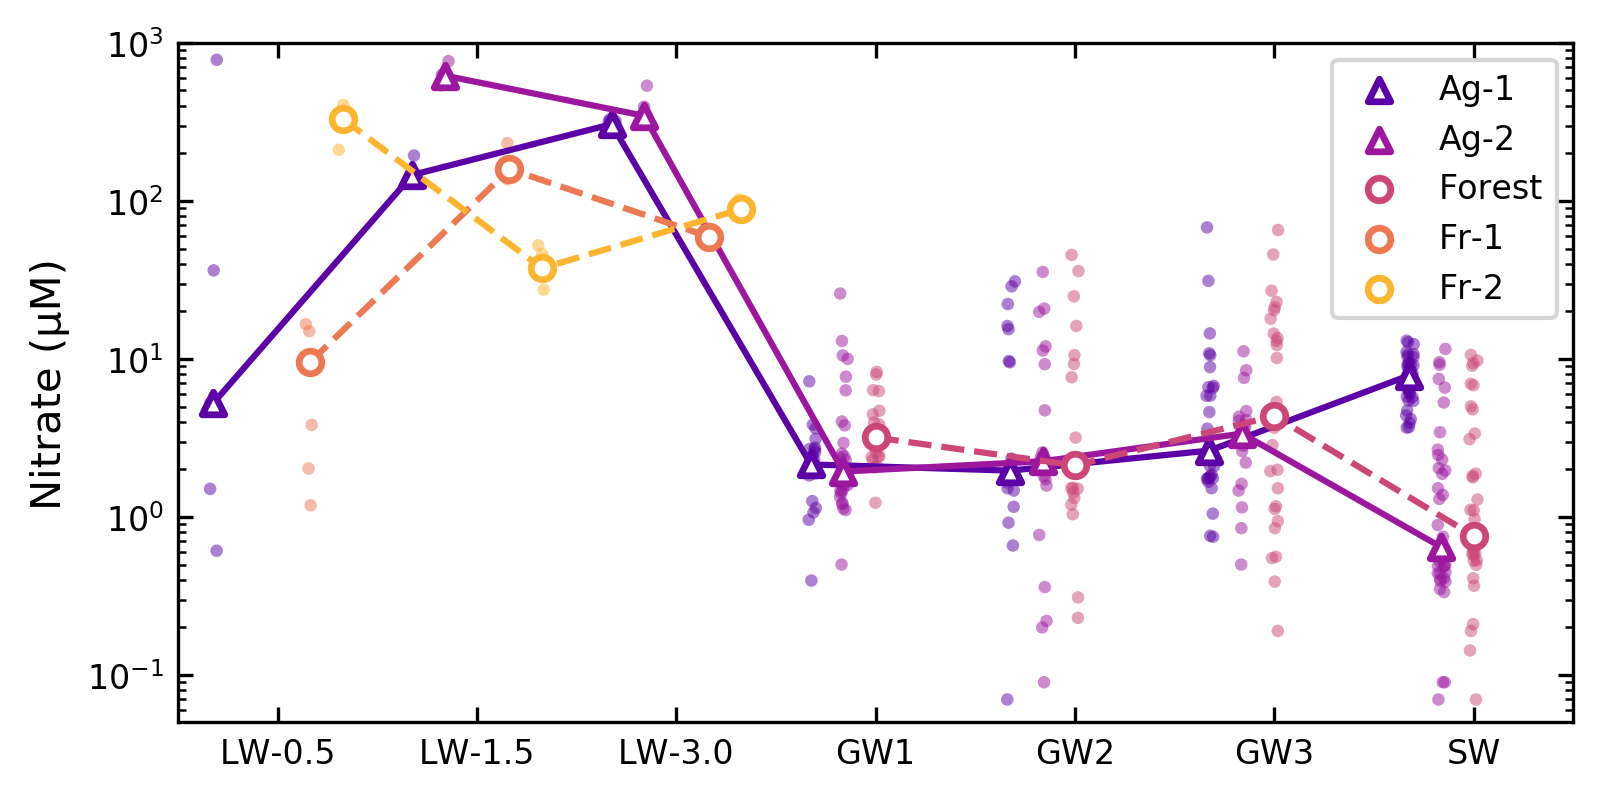

In [140]:
# order = ['AE','LW','GW','SW']
# order = ['AE-0.0','AE-0.5','AE-1.0','AE-2.0','AE-3.0','AE-4.0','LW-0.5','LW-1.5','LW-3.0','GW','SW']
# order = ['LW-0.5','LW-1.5','LW-3.0','GW','SW']
order = ['LW-0.5','LW-1.5','LW-3.0','GW1','GW2','GW3','SW']
fig,ax = plt.subplots(figsize=(6,3),dpi=300)

# make grouped boxplot
# ax = sns.boxplot(y='NO3_mM', x='kind',data=tidy.sort_values(by='location'),order=order,
#                  palette='gray',hue='location',zorder=1, fliersize=0
#                 )

ax = sns.pointplot(y='NO3_uM', x='kind',data=tidy.sort_values(by='location'),order=order,estimator=np.median,
                   palette='plasma',dodge=0.65,hue='location',zorder=1, capsize=0.02,facecolor='w',errwidth=1,
                   scale=.8,
                   seed=1,
                   ci=0,
                   markers=['^','^','o','o','o'],
                   linestyles=['-','-','--','--','--']
                )

 # adjust the line widths
plt.setp(ax.lines, linewidth=1.5)
# make grouped stripplot
ax = sns.stripplot(y='NO3_uM', x='kind',data=tidy.sort_values(by='location'),order=order,
                   jitter=True,dodge=0.5,alpha=0.5,hue='location',
                   palette='plasma',edgecolor='None',linewidth=1,zorder=0,size=3,
#                    marker=['^','^','o','o','o']
                  )


# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = ax.legend(handles[0:5], labels[0:5])

# ax.grid(ls='--',axis='y',zorder=-1)
ax.tick_params(which='both',direction='in',top=True,right=True)
ax.set_ylim(10**-1.3,1000)
ax.set_yscale('log')
ax.set_ylabel('Nitrate (μM)');
ax.set_xlabel(None)
fig.patch.set_facecolor('w')
# fig.savefig('./test.svg')

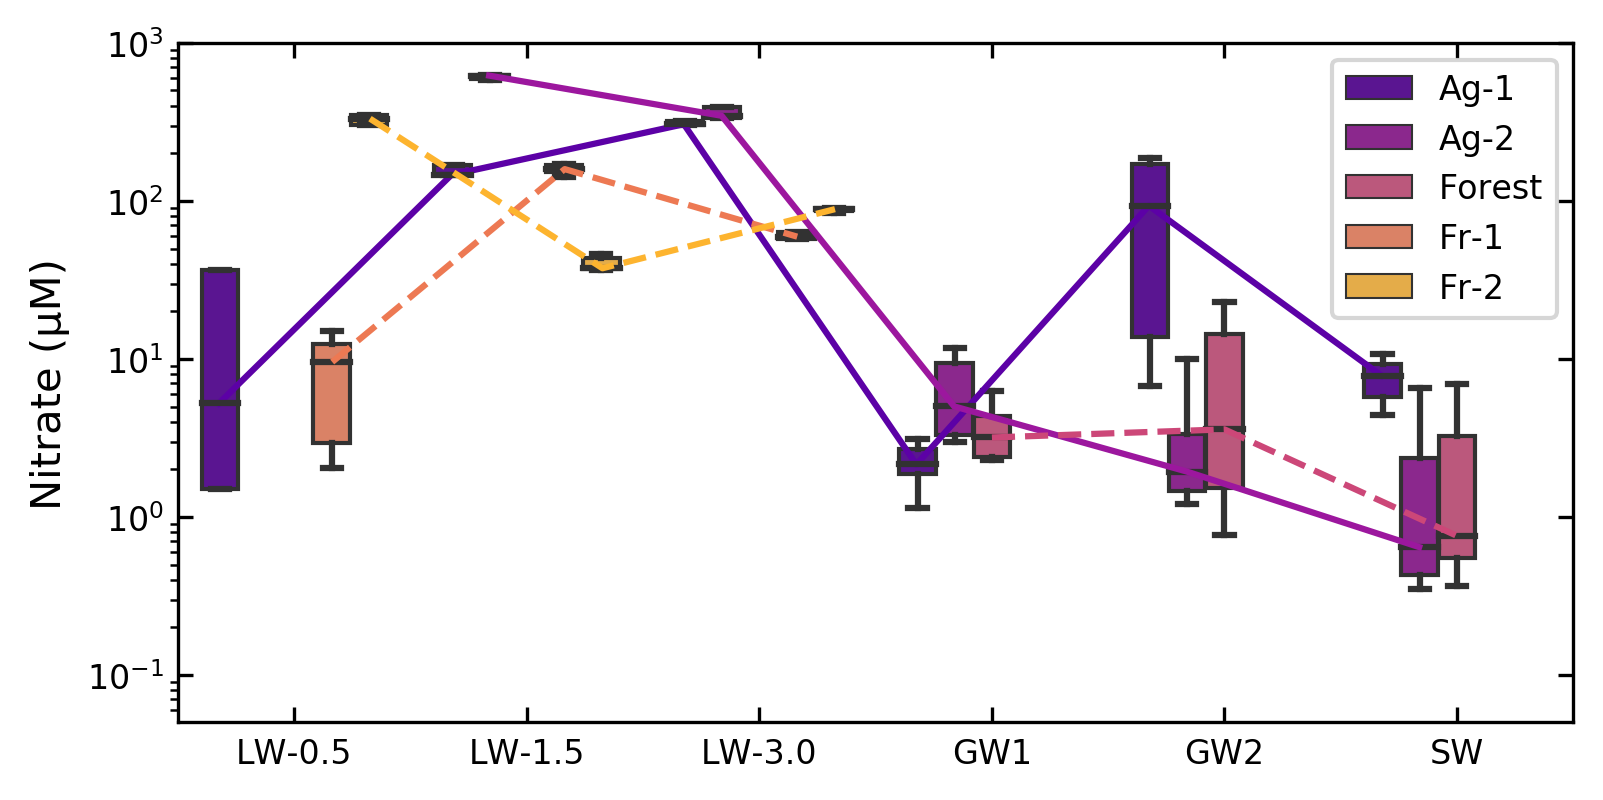

In [273]:
# order = ['AE','LW','GW','SW']
# order = ['AE-0.0','AE-0.5','AE-1.0','AE-2.0','AE-3.0','AE-4.0','LW-0.5','LW-1.5','LW-3.0','GW','SW']
# order = ['LW-0.5','LW-1.5','LW-3.0','GW','SW']
order = ['LW-0.5','LW-1.5','LW-3.0','GW1','GW2','SW']
fig,ax = plt.subplots(figsize=(6,3),dpi=300)

# make grouped boxplot
ax = sns.boxplot(y='NO3_uM', x='kind',data=tidy.sort_values(by='location'),order=order,
                 palette='plasma',hue='location',zorder=1, fliersize=0,linewidth=1,whis=(10,90)
                )
# make grouped stripplot
# ax = sns.stripplot(y='NO3_uM', x='kind',data=tidy.sort_values(by='location'),order=order,
#                    jitter=True,dodge=0.5, marker='o', alpha=0.3,hue='location',
#                    palette='plasma',linewidth=1,zorder=2,size=3
#                   )
ax = sns.pointplot(y='NO3_uM', x='kind',data=tidy.sort_values(by='location'),order=order,estimator=np.median,
                   palette='plasma',dodge=0.65,hue='location',zorder=1, capsize=0.0,facecolor='w',errwidth=1,
                   scale=.8,
                   seed=1,
                   ci=0,
                   markers=['','','','',''],
                   linestyles=['-','-','--','--','--']
                )

 # adjust the line widths
plt.setp(ax.lines, linewidth=1.5)

# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
l = ax.legend(handles[0:5], labels[0:5])

ax.tick_params(direction='in',top=True,right=True)
ax.set_ylim(10**-1.3,1000)
ax.set_yscale('log')
ax.set_ylabel('Nitrate (μM)');
ax.set_xlabel(None)
fig.patch.set_facecolor('w')
